In [2]:
#Import API
from dora.api import DataExplorer

import pandas as pd
from datetime import date, timedelta
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from uszipcode import ZipcodeSearchEngine
import numpy as np

explorer = DataExplorer()

In [3]:
def plot3d(X,x,y,z,points,title):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    colors = ['green','red','blue','black','salmon','indigo','plum','seagreen','grey','yellow']
    for i in range(points):
        ax.scatter(X.results[i][x], X.results[i][y],X.results[i][z], c=colors[X.results[i][12]])
    ax.set_title(title)
    return fig

In [4]:
def custPerCluster(df):
    fig=plt.figure()
    maxn=df['cluster'].max()
    plt.hist(df['cluster'].values)
    plt.xlabel('Clusters')
    plt.ylabel('# of Customers')
    plt.xticks(range(0,maxn+1))
    plt.title('Number of Customers per Cluster')
    return fig

In [5]:
def clusterDist(df):
    maxn=df['cluster'].max()
    clusterStats=pd.DataFrame()
    for i in range(maxn+1):
        mask=(df['cluster']==i)
        t=df.loc[mask]
        clusterStats.loc[i,'avgNumOrders']=t['numorders'].mean()
        clusterStats.loc[i,'avgTotalSpent']=t['totalspent'].mean()
        clusterStats.loc[i,'numHouseholds']=t['householdid'].nunique()
        clusterStats.loc[i,'numZipcoes']=t['zipcode'].nunique()
        clusterStats.loc[i,'avgTotalPopMales']=t['totalmales'].mean()
        clusterStats.loc[i,'avgTotalPopFemales']=t['totalfemales'].mean()
        clusterStats.loc[i,'avgTotalPop']=t['totalpop'].mean()
        clusterStats.loc[i,'medianAge']=t['medianage'].median()
    return clusterStats

In [6]:
def clusterZips(df):
    maxn=df['cluster'].max()
    search = ZipcodeSearchEngine()
    zipstates={}
    zipcities={}
    for i in range(maxn+1):
        #print ("Cluster "+str(i))
        states=set()
        cities=set()
        mask=(df['cluster']==i)
        t=df[['zipcode','cluster']].loc[mask]
        zipcodes=t['zipcode'].unique()
        for j in range(len(zipcodes)):
            city=search.by_zipcode(str(zipcodes[j]))
            cities.add(city['City'])
            states.add(city['State'])
        zipstates.update({i:states})
        zipcities.update({i:cities})
    return zipstates, zipcities

statsByCustomer Query

In [7]:
statsByCust=explorer.customers.statsByCustomer()
statsByCustomer=pd.DataFrame(statsByCust.results, columns=statsByCust.columns)
statsByCustomer.head()

,customermatchedid,numorders,gender,zipcode,totalpop,medianage,totalmales,totalfemales,totalspent,householdid,firstname,numcustomerid
0,37917,412,0,10036,22413,38.8,12687,9726,606.25,19885296,MIKE,412
1,37907,189,1,10036,22413,38.8,12687,9726,651.59,19885296,HILDA,189
2,140299,99,0,10036,22413,38.8,12687,9726,0.00,49927024,MIKE,99
3,37901,99,2,10036,22413,38.8,12687,9726,2226.32,19885296,,99
4,140298,70,0,10036,22413,38.8,12687,9726,0.00,49927024,JIM,70


Use the API to get 10 clusters of customers. Bad zipcodes have been removed from the dataset. Customers with no gender assigned are within the dataset of customers to be clustered. A specified feature_set is not defined by the user, neither are the features that will be used for the clustering. In this case, the feature_set will be the data from statsByCustomer and the features will be [numOrders, gender, totalpop, totalspent]. 

In [8]:
#Get 10 clusters and print out the head of the dataframe
cCluster=explorer.customers.clusterCustomers(n_clusters=10)

In [9]:
#Lists the columns of the cCluster
cCluster.columns

array(['numorders', 'gender', 'totalpop', 'totalspent', 'zipcode',
       'medianage', 'totalmales', 'totalfemales', 'customermatchedid',
       'householdid', 'firstname', 'numcustomerid', 'cluster',
       'customerids'], dtype=object)

In [11]:
#3-D Plot of the customer clusters (gender, medianage, totalpop)
#plot=plot3d(cCluster, 1,5, 2, 1000)
#plot

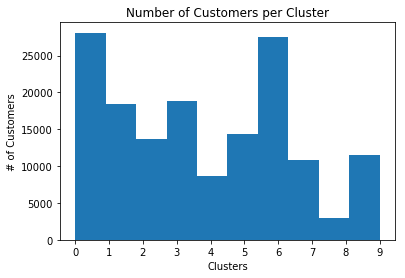

In [12]:
#Histogram of the number of customers in each cluster
df=pd.DataFrame(cCluster.results, columns=cCluster.columns)
dist=custPerCluster(df)
dist

In [13]:
#Stats by cluster
stats=clusterDist(df)
stats

,avgNumOrders,avgTotalSpent,numHouseholds,numZipcoes,avgTotalPopMales,avgTotalPopFemales,avgTotalPop,medianAge
0,1.189666,84.236432,27945.0,2953.0,4558.673333,4821.535798,9380.209131,42.6
1,1.172296,96.599905,18309.0,1976.0,9965.402730,10171.364225,20136.766955,40.4
2,1.211923,84.352935,13587.0,204.0,28215.088363,31156.155019,59371.243382,38.1
3,1.202103,79.012609,18735.0,483.0,19303.648736,21139.251168,40442.899904,39.7
4,1.178629,77.982390,8640.0,649.0,21130.368336,22451.555158,43581.923494,37.1
5,1.177838,78.103896,14250.0,1559.0,10802.908253,11500.980519,22303.888773,40.8
6,1.234431,81.670000,27357.0,735.0,11797.648245,12727.793184,24525.441429,41.3
7,1.176498,89.897166,10834.0,2093.0,8696.785405,9192.391460,17889.176866,39.8
8,1.214528,64.909121,2932.0,44.0,42748.086219,48323.650373,91071.736592,37.7
9,1.167393,82.538887,11435.0,1019.0,22125.439613,22720.229000,44845.668613,37.2


In [14]:
#Get the states and cities that are clustered together
zipdata=clusterZips(df)
zipstates=zipdata[0]
zipcities=zipdata[1]

Cluster the customers but remove certain householdids. Specifiy the features that will be used in the clustering. 

In [15]:
#Elimate householdids from the data that will be clustered
response=explorer.customers.statsByCustomer(householdid=['19885296','49927024'])

In [16]:
#Show results from the query
response.results

[(72872,
  28,
  2,
  Decimal('11354'),
  55543,
  42.1,
  26770,
  28773,
  Decimal('1218.96'),
  22269801,
  'PO-WEN',
  28),
 (108804,
  26,
  1,
  Decimal('10168'),
  0,
  None,
  0,
  0,
  Decimal('0.00'),
  36201520,
  'NANCY',
  26),
 (28252,
  24,
  0,
  Decimal('10036'),
  22413,
  38.8,
  12687,
  9726,
  Decimal('814.56'),
  19440306,
  'PETER',
  24),
 (116601,
  21,
  2,
  Decimal('11590'),
  44977,
  36.7,
  21660,
  23317,
  Decimal('3312.75'),
  36209331,
  '',
  21),
 (32345,
  17,
  0,
  Decimal('44122'),
  33662,
  46.4,
  15295,
  18367,
  Decimal('3757.26'),
  19626230,
  'JEROME',
  17),
 (7661,
  16,
  0,
  Decimal('11375'),
  69745,
  42.0,
  31484,
  38261,
  Decimal('443.32'),
  18474444,
  'RON',
  16),
 (53852,
  16,
  0,
  Decimal('11230'),
  84707,
  34.3,
  41061,
  43646,
  Decimal('520.74'),
  20656767,
  'ELI',
  16),
 (30252,
  16,
  0,
  Decimal('61021'),
  23706,
  41.9,
  12512,
  11194,
  Decimal('2053.18'),
  19535255,
  'EDWARD',
  16),
 (18640,

In [23]:
#Cluster the results by customer
cCluster_rmHID=explorer.customers.clusterCustomers(feature_set=response, n_clusters=7, 
                                                   cluster_on=['gender','totalmales','totalfemales','totalpop'])

In [29]:
#Get cluster stats
df=pd.DataFrame(cCluster_rmHID.results, columns=cCluster_rmHID.columns )
stats=clusterDist(df)
stats

,avgNumOrders,avgTotalSpent,numHouseholds,numZipcoes,avgTotalPopMales,avgTotalPopFemales,avgTotalPop,medianAge
0,1.191048,82.670200,35494.0,2054.0,13652.171382,14551.475284,28203.646666,40.1
1,1.193533,79.553550,14460.0,634.0,24374.611358,26062.653833,50437.265191,36.3
2,1.179812,91.091239,29026.0,4948.0,3608.861019,3723.810634,7332.671653,43.1
3,1.212001,65.252829,3010.0,66.0,42834.013848,48141.761292,90975.775140,37.7
4,1.190701,81.293158,25130.0,1281.0,18855.824050,20260.883880,39116.707930,39.0
5,1.188480,84.611990,35963.0,2522.0,8863.315029,9370.739637,18234.054666,41.3
6,1.201137,83.321236,10113.0,287.0,30468.041070,33499.317977,63967.359047,38.3


In [30]:
df['cluster'].unique()

array([1, 2, 5, 4, 6, 3, 0])

In [31]:
cCluster_rmHID.columns

array(['gender', 'totalmales', 'totalfemales', 'totalpop',
       'customermatchedid', 'numorders', 'zipcode', 'medianage',
       'totalspent', 'householdid', 'firstname', 'numcustomerid',
       'cluster', 'customerids'], dtype=object)

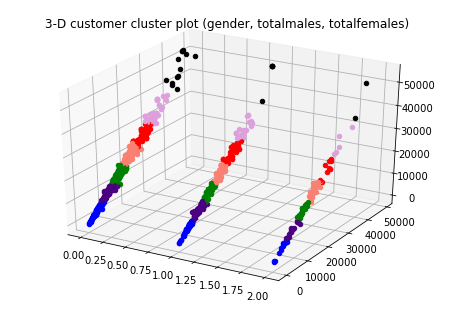

In [32]:
#3-D Plot of the customer clusters (gender, totalmales , totalfemales)
plot=plot3d(cCluster_rmHID, 0, 1, 2, 1000, "3-D customer cluster plot (gender, totalmales, totalfemales)")
plot

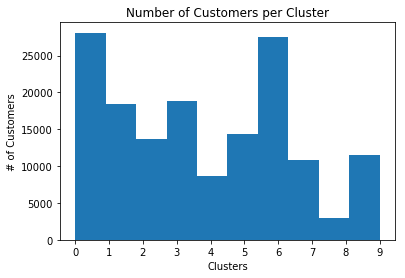

In [33]:
df=pd.DataFrame(cCluster.results, columns=cCluster.columns)
dist=custPerCluster(df)
dist